Загрузка и предварительный анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
data = pd.read_csv(url, names=names)

# Просмотр первых нескольких строк данных
print(data.head())

# Просмотр информации о данных
print(data.info())

# Статистика данных
print(data.describe())


    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca thal  target  
0    3.0  0.0  6.0       0  
1    2.0  3.0  3.0       2  
2    2.0  2.0  7.0       1  
3    3.0  0.0  3.0       0  
4    1.0  0.0  3.0       0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-n

Масштабирование признаков

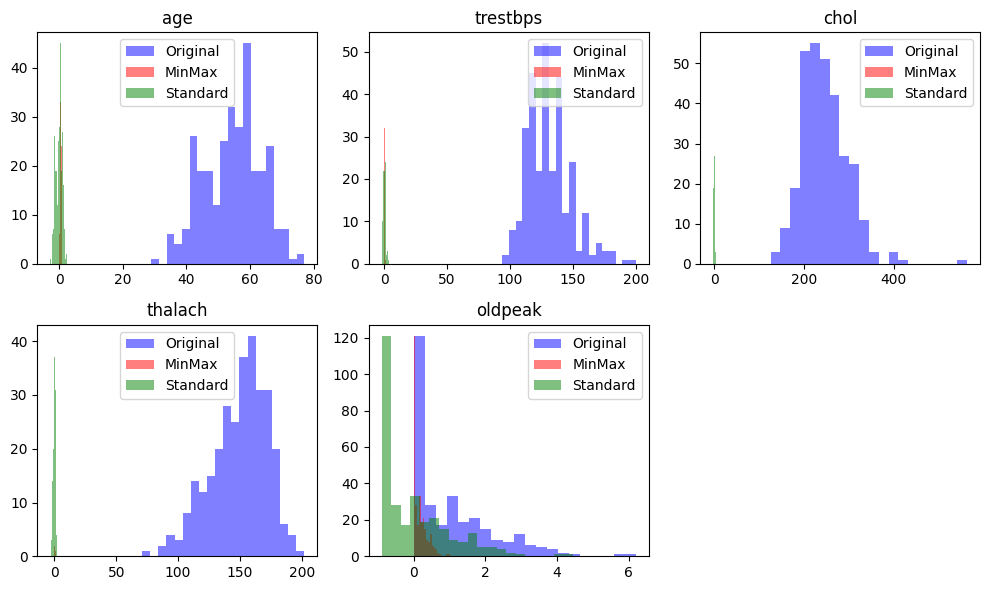

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Выбор числовых признаков для масштабирования
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Масштабирование признаков
scaler_minmax = MinMaxScaler()
data_minmax = scaler_minmax.fit_transform(data[numeric_features])

scaler_std = StandardScaler()
data_std = scaler_std.fit_transform(data[numeric_features])

# Визуализация эффекта масштабирования
plt.figure(figsize=(10, 6))
for i, feature in enumerate(numeric_features):
    plt.subplot(2, 3, i+1)
    plt.hist(data[feature], bins=20, alpha=0.5, color='blue', label='Original')
    plt.hist(data_minmax[:,i], bins=20, alpha=0.5, color='red', label='MinMax')
    plt.hist(data_std[:,i], bins=20, alpha=0.5, color='green', label='Standard')
    plt.title(feature)
    plt.legend()
plt.tight_layout()
plt.show()


 Обработка выбросов для числовых признаков

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


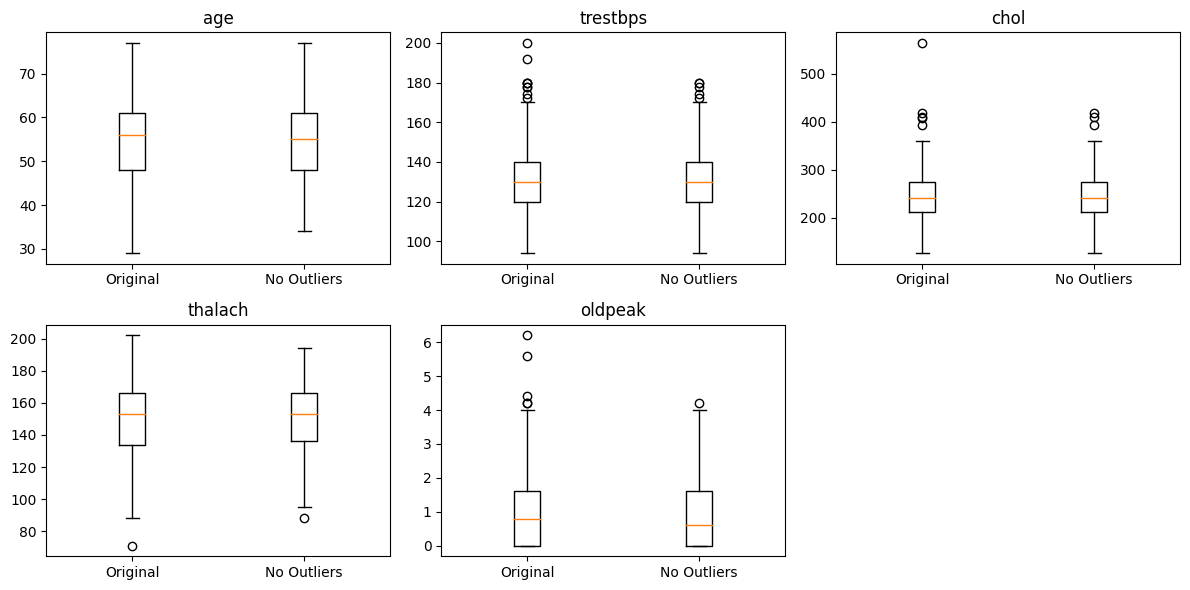

In [3]:
from sklearn.ensemble import IsolationForest

# Обучение модели для определения выбросов
clf = IsolationForest(contamination=0.05, random_state=42)
outliers = clf.fit_predict(data[numeric_features])

# Удаление выбросов
data_no_outliers = data[outliers == 1]

# Визуализация эффекта удаления выбросов
plt.figure(figsize=(12, 6))
for i, feature in enumerate(numeric_features):
    plt.subplot(2, 3, i+1)
    plt.boxplot([data[feature], data_no_outliers[feature]], labels=['Original', 'No Outliers'])
    plt.title(feature)
plt.tight_layout()
plt.show()


Обработка нестандартного признака

In [4]:
# Пример: кодирование категориального признака cp с использованием one-hot encoding
data_encoded = pd.get_dummies(data, columns=['cp'])
print(data_encoded.head())


    age  sex  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0  63.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3    3.0   
1  67.0  1.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5    2.0   
2  67.0  1.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6    2.0   
3  37.0  1.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5    3.0   
4  41.0  0.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4    1.0   

    ca thal  target  cp_1.0  cp_2.0  cp_3.0  cp_4.0  
0  0.0  6.0       0    True   False   False   False  
1  3.0  3.0       2   False   False   False    True  
2  2.0  7.0       1   False   False   False    True  
3  0.0  3.0       0   False   False    True   False  
4  0.0  3.0       0   False    True   False   False  


Отбор признаков

In [9]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

data.replace('?', np.nan, inplace=True)
data = data.apply(pd.to_numeric, errors='coerce')
data.dropna(inplace=True)

X = data.drop(columns=['target'])
y = data['target']

# Filter method: Метод корреляции
best_features_filter = SelectKBest(score_func=chi2, k=5)
best_features_filter.fit(X, y)
X_filtered = best_features_filter.transform(X)

# Wrapper method: Рекурсивное исключение признаков (RFE) с логистической регрессией
estimator = LogisticRegression(solver='liblinear', max_iter=1000)
rfe = RFE(estimator, n_features_to_select=5, step=1)
rfe.fit(X, y)
X_rfe = rfe.transform(X)

# Embedded method: Lasso с логистической регрессией
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear', max_iter=1000))
embeded_lr_selector.fit(X, y)
X_embedded = embeded_lr_selector.transform(X)
